# Import all libraries

In [1]:
# 10/9/2018
# Daniel Karamitrov

# the most important ones
import pandas as pd
import numpy as np

from enum import Enum # Action types enumeration

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn import svm # model/estimator for pipeline ending
import random # generate random ints
import sklearn_pandas as skpd # DataFrameMapper


from sklearn.pipeline import Pipeline, FeatureUnion

import os # generate random bytes
from base64 import b64encode # encode randombytes as a string

# do %matplotlib inline for interactive plots (unstable)
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm # color map for displaying action
from matplotlib.lines import Line2D # for creating a custom legend element

from datetime import *

# Data Generator
Randomly generator actions per contact. For each action:
+ Associate it with an action type
+ Associate it with a random email (`deliveryID`)
+ Associate it with a random link ID (all emails have a fixed set of links) This is only relevant for actions of type VIEW_LINK.
+ Apply a random time delta for the timestamp. This is converted later to minutes and added to a `datetime` offset in the pandas DataFrame.

In [2]:
###### DATA GENERATOR STARTS HERE
# Enumerate action types, so that they can be stored as uint8 and displayed as a string
class Action(Enum):
    EMAIL_VIEW_LINK = 0
    EMAIL_WEBFORM_UNSUB = 1
    EMAIL_WEBFORM_FTAF = 2
    EMAIL_WEBFORM_VIEW = 3
    CUSTOM_ACTION_A = 4
    CUSTOM_ACTION_B = 5
    CUSTOM_ACTION_C = 6



random.seed(42)
#
TOTAL_CONTACTS = 20
TOTAL_EMAILS = 20

contactIDs = ["c_{:05d}".format(i) for i in range(0, TOTAL_CONTACTS)]
deliveryIDs = ["d_{:05d}".format(i) for i in range(0, TOTAL_EMAILS)]

allDelivery = {}

# TODO: generate fixed set of linkIDs per email
for dID in deliveryIDs:
    allDelivery[dID] = []

# list of all actions when instantiating the DataFrame
allActions = []

# helper function to generate a random string
def gen_rand_str():
    return b64encode(os.urandom(6))

# for each contact
for contact in contactIDs:
    for j in range(0, 21):
        allActions.append([
            contact,
            random.randint(0,3),
            deliveryIDs[random.randint(0, len(deliveryIDs)-1)],
            random.randint(0, 1000),
            "v_"
        ])

columns = ['contactID', 'actionID', 'deliveryID', 'timestamp', 'linkID']

raw_df = pd.DataFrame(columns=columns, data=allActions)

# use the integer timestamp field as a timedelta in minutes and add it to a fixed offset for all contacts
# TODO: randomize fixed offset
raw_df['timestamp'] = raw_df['timestamp'].apply(lambda t: pd.to_datetime(timedelta(minutes=t) + datetime(2014, 11, 17)))

The raw dataset will be imported as a pandas dataframe. Below is an example of indexing the DataFrame and displaying the first 2 actions of each unique contact, only from the first 100 rows.

In [3]:
raw_df[0:100].groupby('contactID').head(2)

,contactID,actionID,deliveryID,timestamp,linkID
0,c_00000,0,d_00000,2014-11-17 12:39:00,v_
1,c_00000,2,d_00007,2014-11-17 03:48:00,v_
21,c_00001,2,d_00014,2014-11-17 10:50:00,v_
22,c_00001,2,d_00005,2014-11-17 06:19:00,v_
42,c_00002,0,d_00012,2014-11-17 06:30:00,v_
43,c_00002,3,d_00016,2014-11-17 04:17:00,v_
63,c_00003,1,d_00009,2014-11-17 06:48:00,v_
64,c_00003,2,d_00014,2014-11-17 15:21:00,v_
84,c_00004,1,d_00013,2014-11-17 03:07:00,v_
85,c_00004,2,d_00014,2014-11-17 04:15:00,v_


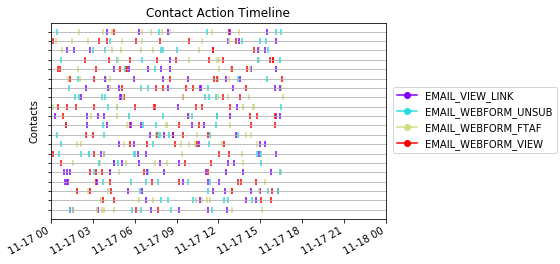

In [4]:
###### PLOT CONTACT ACTION DATA FOR VISUALS
# derivative work of the following, modified to plot by date and per contact
# https://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib
def dfScatter(df, xcol='timestamp', ycol='contactID', catcol='actionID'):
    fig, ax = plt.subplots()
    categories = np.unique(df[catcol])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))
    
    legend_colors = cm.hsv(colors)

    df["Color"] = df[catcol].apply(lambda x: colordict[x])
    ax.scatter(df[xcol].tolist(), df[ycol].tolist(), cmap='rainbow',c=df.Color, marker='|')
    ax.set_xlim([date(2014, 11, 17), date(2014, 11, 18)])
    ax.yaxis.set_ticklabels([])
    ax.set_ylabel("Contacts")
    legend_elements = [Line2D([0], [0], marker='o', color=cm.rainbow(colordict[c]),
                              label=Action(c).name) for c in categories]
    fig.legend(loc='right',bbox_to_anchor=(1.3, 0.5),handles=legend_elements)
    fig.autofmt_xdate()
    ax.set_title('Contact Action Timeline')
    ax.yaxis.grid(True)
    return fig


fig = dfScatter(raw_df, xcol='timestamp', ycol='contactID', catcol='actionID')
fig.savefig('fig1.png', bbox_inches='tight', dpi=400)

The raw dataset can also be visualized as a timeline, with variables `timestamp` versus `contactID`. Each tick mark represents an action by the contact with different action types by color.

# Feature Extraction
The prediction models (the things that implement `.fit(X,y)` and `.predict(X)->y`) themselves ***CANNOT*** interpret the raw dataset. It is up to us to utilize a variety of feature extraction methods to generate a set of consistent measurements from the raw data. Consistent as in the same raw input will map to the same transformed output (i.e. *total value map*).

In [5]:
###### FEATURE EXTRACTION STARTS HERE!!!
feature_df = pd.DataFrame()

## fExtraction Example 1 - Contact Lifespan
Calculate the 'lifespan' of a user by from their first recorded action in the sample to the last one they made. This can be done in ***ONE LINE*** using pandas.

In [6]:
# Add a column for the new feature.
# When you call groupby, you are forking the execution of how the data is processed. In this case, we are grouping
# by contactID, selecting the 'timestamp' column, and running some function for each series of timestamps.
per_contact_lifespan = raw_df.groupby('contactID')['timestamp'].apply(lambda x: x.max() - x.min())
# insert into final per-contact feature matrix
feature_df['lifespan'] = per_contact_lifespan

## fExtraction Example 2 - CountVectorizer via Contact Action Sequence
Google and read scikit learn article on CountVectorizer. This applies to our framework if we imagine the sequence of actions per-contact as a sentence. This sentence describes a story of what the contact did. We can utilize proven and mature machine learning feature extraction methods for text analysis on these action sequences.

Keep in mind this is accounting for the full sequence of contact actions as a single 'document' from a TFIDF context.



In [7]:
# fork the computation on a per-contact basis. Read the pandas docs on .groupby (all 10 pages.)
per_contact_group = raw_df.groupby('contactID')
# cdp means contact DataPanel, a subview in the raw dataframe.
per_contact_action_sequences = per_contact_group.apply( # per-contact, run the following lambda
    lambda cdp: cdp['actionID'] # looking at only the actions a user took
    .to_string(index=False,header=False) # concatenate all actions into a string
    .replace('\n',' ')) # replace all newlines with spaces so it's easier to read later

# TODO: using .replace() here is not efficient. .to_string() has a buffer param which can
# reduce the overhead of manually replacing '\n' by doing it as it is buffered.

# display the sequence strings per-contact
per_contact_action_sequences

contactID
c_00000    0 2 1 0 0 1 0 3 2 1 2 2 3 2 0 0 2 2 0 1 1
c_00001    2 2 2 2 1 1 3 1 0 0 2 2 3 3 1 2 3 1 0 0 1
c_00002    0 3 0 2 2 3 2 1 0 1 1 0 3 2 0 0 3 1 3 2 3
c_00003    1 2 3 1 0 1 0 0 0 1 3 1 3 3 0 3 3 0 3 0 1
c_00004    1 2 0 0 0 1 3 3 3 2 3 3 2 0 0 0 1 0 0 0 0
c_00005    3 2 2 3 2 0 0 1 1 0 2 2 0 0 0 1 1 2 2 3 0
c_00006    1 3 3 0 1 2 1 0 0 1 3 1 1 3 2 1 0 0 1 2 0
c_00007    2 0 3 0 2 2 3 2 0 1 3 1 0 2 2 3 2 1 3 2 0
c_00008    1 2 3 3 0 2 1 1 0 0 1 3 0 3 3 1 1 2 3 1 2
c_00009    2 1 0 2 0 1 1 3 3 1 0 3 2 3 1 2 0 3 3 0 0
c_00010    3 3 2 1 2 3 0 0 0 0 0 1 0 1 2 0 2 0 3 1 1
c_00011    2 0 0 3 2 3 3 3 1 2 3 2 1 3 3 3 3 3 2 2 1
c_00012    3 1 3 0 1 1 2 2 2 3 2 1 1 3 2 1 2 0 2 0 1
c_00013    0 3 2 0 3 0 0 0 2 0 3 1 3 3 0 0 1 0 1 1 3
c_00014    2 2 3 1 1 1 2 0 2 2 3 3 3 0 2 0 0 0 3 3 0
c_00015    3 0 3 3 3 2 3 0 3 2 3 0 1 3 1 0 0 0 0 2 2
c_00016    3 3 3 1 3 2 2 3 3 3 2 1 1 2 3 1 0 2 3 3 1
c_00017    1 2 3 2 2 0 1 0 0 2 2 2 1 3 1 0 3 1 1 2 0
c_00018    2 0 2 3 2 3 3 2 3 0 3 1 2

Transformation of each contact's set of actions concatenated into a string.

+ TODO: stop word insertion for email deliveries into the sequences, denoted by some char 'E'
+ TODO: stop word insertion for long spans of no activity, denoted by some char 'N'

## CountVectorizer 101 Example
Below is a simple example using CountVectorization for ngram sizes of 1 and 2. Pay close attention to the output. It is literally a count of all occuring permutations in the given corpus, or body of documents.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.toarray())

['and', 'and this', 'document', 'document is', 'first', 'first document', 'is', 'is the', 'is this', 'one', 'second', 'second document', 'the', 'the first', 'the second', 'the third', 'third', 'third one', 'this', 'this document', 'this is', 'this the']
[[0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0]
 [0 0 2 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0]
 [0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1]]


## CountVectorizer Applied to Contact Actions via Sessions
One important detail to note about the above example is that CountVectorizer (and TfIdf) requires a ***corpus*** of documents to learn the vocabulary and n-grams of the language. In our case, we ***must not consider the corpus to be across all contacts. This is not correct. The corpus of documents must be derived on a per-contact basis only. No mixing of contact sentences.***

To derive a corpus, we must partition the contact's action sequence in by one of the following methods:
+ random partitions
+ random overlapping partitions
+ half-half, 

While all of these methods are easy to implement, the *best* way to derive all documents and preserve sequence context, is to partition the data by the use of *unsupervised clustering analysis*. In some version of this implementation, make use of sci-kit learn DBSCAN to group per-contact actions by the time the action was made. This will try to capture the contact's behavior. I will not do that here.

Now for the example.

In [9]:
# please review sklearn.feat_extract.text.CountVectorizer for full
# list of params to manipulate ngram/term frequency counting

# token_pattern must be set here because tokens by default
# are expected to be at least 2 alphanumeric chars

# This countvectorizer will use ngrams of length 1 or 2. Better implementations
# could use a greater number and include some heuristic to filter useless ngrams
vectorizer = CountVectorizer(ngram_range=(1,3), token_pattern='[0-9]+')
X = vectorizer.fit_transform(per_contact_action_sequences.tolist())
print("Feature names:\n",vectorizer.get_feature_names())

print("Feature values per-contact:\n",X.toarray())

# cast to floats for later
# X = X.astype(float)

per_contact_countvectorizer_features = pd.DataFrame(columns=vectorizer.get_feature_names(),
             data=X.toarray(),
            index=feature_df.index)

feature_df[vectorizer.get_feature_names()] = per_contact_countvectorizer_features

per_contact_countvectorizer_features

Feature names:
 ['0', '0 0', '0 0 0', '0 0 1', '0 0 2', '0 0 3', '0 1', '0 1 0', '0 1 1', '0 1 2', '0 1 3', '0 2', '0 2 0', '0 2 1', '0 2 2', '0 2 3', '0 3', '0 3 0', '0 3 1', '0 3 2', '0 3 3', '1', '1 0', '1 0 0', '1 0 1', '1 0 2', '1 0 3', '1 1', '1 1 0', '1 1 1', '1 1 2', '1 1 3', '1 2', '1 2 0', '1 2 1', '1 2 2', '1 2 3', '1 3', '1 3 0', '1 3 1', '1 3 2', '1 3 3', '2', '2 0', '2 0 0', '2 0 1', '2 0 2', '2 0 3', '2 1', '2 1 0', '2 1 1', '2 1 2', '2 1 3', '2 2', '2 2 0', '2 2 1', '2 2 2', '2 2 3', '2 3', '2 3 0', '2 3 1', '2 3 2', '2 3 3', '3', '3 0', '3 0 0', '3 0 1', '3 0 2', '3 0 3', '3 1', '3 1 0', '3 1 1', '3 1 2', '3 1 3', '3 2', '3 2 0', '3 2 1', '3 2 2', '3 2 3', '3 3', '3 3 0', '3 3 1', '3 3 2', '3 3 3']
Feature values per-contact:
 [[7 2 0 ... 0 0 0]
 [4 2 0 ... 1 0 0]
 [6 1 0 ... 0 0 0]
 ...
 [5 1 0 ... 0 0 0]
 [3 0 0 ... 0 1 0]
 [5 1 0 ... 0 0 0]]


,0,0 0,0 0 0,0 0 1,0 0 2,0 0 3,0 1,0 1 0,0 1 1,0 1 2,...,3 2,3 2 0,3 2 1,3 2 2,3 2 3,3 3,3 3 0,3 3 1,3 3 2,3 3 3
contactID,,,,,,,,,,,,,,,,,,,,,
c_00000,7,2,0,1,1,0,2,1,1,0,...,2,1,1,0,0,0,0,0,0,0
c_00001,4,2,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
c_00002,6,1,0,0,0,1,1,0,1,0,...,3,1,1,0,1,0,0,0,0,0
c_00003,7,2,1,1,0,0,3,1,0,0,...,0,0,0,0,0,2,2,0,0,0
c_00004,10,7,4,2,0,0,2,1,0,0,...,2,1,0,0,1,3,0,0,2,1
c_00005,7,3,1,2,0,0,2,0,2,0,...,2,1,0,1,0,0,0,0,0,0
c_00006,6,2,0,2,0,0,3,0,0,2,...,1,0,1,0,0,1,1,0,0,0
c_00007,5,0,0,0,0,0,1,0,0,0,...,3,2,1,0,0,0,0,0,0,0
c_00008,4,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,2,1,1,0,0


## fExtraction Example 3 - TfIdf via Contact Session Action Sequence
Similar to the above example but we must go out of the way to aggregate user actions by the time they occured. Each one of these 'sessions' is its own document/sentence.


# Final Outcome of Feature Extraction

In [10]:
feature_df

,lifespan,0,0 0,0 0 0,0 0 1,0 0 2,0 0 3,0 1,0 1 0,0 1 1,...,3 2,3 2 0,3 2 1,3 2 2,3 2 3,3 3,3 3 0,3 3 1,3 3 2,3 3 3
contactID,,,,,,,,,,,,,,,,,,,,,
c_00000,13:46:00,7,2,0,1,1,0,2,1,1,...,2,1,1,0,0,0,0,0,0,0
c_00001,12:11:00,4,2,0,1,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
c_00002,14:22:00,6,1,0,0,0,1,1,0,1,...,3,1,1,0,1,0,0,0,0,0
c_00003,14:19:00,7,2,1,1,0,0,3,1,0,...,0,0,0,0,0,2,2,0,0,0
c_00004,15:33:00,10,7,4,2,0,0,2,1,0,...,2,1,0,0,1,3,0,0,2,1
c_00005,14:17:00,7,3,1,2,0,0,2,0,2,...,2,1,0,1,0,0,0,0,0,0
c_00006,15:58:00,6,2,0,2,0,0,3,0,0,...,1,0,1,0,0,1,1,0,0,0
c_00007,14:36:00,5,0,0,0,0,0,1,0,0,...,3,2,1,0,0,0,0,0,0,0
c_00008,13:55:00,4,1,0,1,0,0,1,0,0,...,0,0,0,0,0,2,1,1,0,0


In [11]:
# cast the lifespan feature to an int in seconds
try:
    feature_df['lifespan'] = feature_df['lifespan'].dt.seconds
except Exception:
    pass
feature_df.head(10)

,lifespan,0,0 0,0 0 0,0 0 1,0 0 2,0 0 3,0 1,0 1 0,0 1 1,...,3 2,3 2 0,3 2 1,3 2 2,3 2 3,3 3,3 3 0,3 3 1,3 3 2,3 3 3
contactID,,,,,,,,,,,,,,,,,,,,,
c_00000,49560,7,2,0,1,1,0,2,1,1,...,2,1,1,0,0,0,0,0,0,0
c_00001,43860,4,2,0,1,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
c_00002,51720,6,1,0,0,0,1,1,0,1,...,3,1,1,0,1,0,0,0,0,0
c_00003,51540,7,2,1,1,0,0,3,1,0,...,0,0,0,0,0,2,2,0,0,0
c_00004,55980,10,7,4,2,0,0,2,1,0,...,2,1,0,0,1,3,0,0,2,1
c_00005,51420,7,3,1,2,0,0,2,0,2,...,2,1,0,1,0,0,0,0,0,0
c_00006,57480,6,2,0,2,0,0,3,0,0,...,1,0,1,0,0,1,1,0,0,0
c_00007,52560,5,0,0,0,0,0,1,0,0,...,3,2,1,0,0,0,0,0,0,0
c_00008,50100,4,1,0,1,0,0,1,0,0,...,0,0,0,0,0,2,1,1,0,0


Final feature table before input to feature selection/aggolmeration and finally the estimator (prediction model).

# Feature Selection
The prediction models may be overwhelmed with noisy or insignificant features. We can omit feature columns through statistical methods:
+ PCA and remove eigenvalues below a threshold
+ Truncated SVD and remove eigenvalues below a threshold
+ ANOVA with some scoring function

We can also "mix" features together. This requires some heuristic/human reasoning to determine if capturing the correlation between two features is valuable.

In [12]:
# TODO: feature selection

# Prediction Model Fitting/Training
Simple.
Train the model using the half of the contacts.
Test the model using the other half of contacts.

Splitting the training and testing data is *model validation*. Specifically, this is the *holdout* method. To perform *model selection*, every other train-n-test instance for other models or hyperparameters must USE THE SAME train-n-test partitions for the 

In [13]:
# Generate some labels for the contacts we have.
# This is random for now.

from sklearn.ensemble import AdaBoostClassifier

# Since we are doing classification, the labels are categorical.
# In this case, we generate them at total random. The prediction model will try its
# best to fit to the labels but 
label_classes = ['Y', 'N']
y_true = np.random.choice(label_classes, TOTAL_CONTACTS).T

# partition train and test labels
y_train = y_true[0:TOTAL_CONTACTS//2]
y_test = y_true[TOTAL_CONTACTS//2:]

X_train = feature_df[0:TOTAL_CONTACTS//2].values
X_test = feature_df[TOTAL_CONTACTS//2:TOTAL_CONTACTS].values

# partition train and test data


# THE PREDICTION MODEL vvvvvv
clf = AdaBoostClassifier()

# TRAIN THE PREDICTION MODEL ON THE FIRST HALF OF CONTACTS
clf.fit(X_train, y_train)


# PREDICT THE LABELS FOR THE SECOND HALF OF CONTACTS
y_predict = clf.predict(X_test)


print("Prediction:\n", y_predict)
print("Truth:\n", y_test)

Prediction:
 ['Y' 'N' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y']
Truth:
 ['Y' 'N' 'N' 'N' 'N' 'Y' 'N' 'Y' 'N' 'N']


# Scoring

In [14]:
from sklearn.metrics import *

In [15]:
print(classification_report(y_test,y_predict))

             precision    recall  f1-score   support

          N       0.67      0.29      0.40         7
          Y       0.29      0.67      0.40         3

avg / total       0.55      0.40      0.40        10



In [16]:
# If the model supports decision_function, we can plot an ROC curve to determine
# AUC, TPR/FPR sensitivity.

# From example : http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
y_score = clf.fit(X_train, y_train).decision_function(X_test)

print(y_score)
print(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[i], y_score[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

[17.78591948 -9.4462972  -0.17575539  9.15023816  0.21240702 17.78591948
  0.21240702 -0.17575539  0.21240702 17.78591948]
['Y' 'N' 'N' 'N' 'N' 'Y' 'N' 'Y' 'N' 'N']


ValueError: Expected array-like (array or non-string sequence), got 'Y'

# Model Performance 💩
Wow. That's it for model validation. But the model did poorly. About 25% average precision. But why?

+ need better feature extraction (find and choose better features)
+ need better feature selection (mix and drop extraneous features)
+ need choose better model (use model selection from sklearn to do GridSearchCV)
+ need better model validation scheme (this is the holdout method without forecasting)

Also, the model validation did not perform prediction in the sense of time or forcasting. All the contacts performed actions within the same period. Better model validation techniques would use a rolling window to train the model on former contact actions and test it on current/future contact actions.

In [ ]:
# Misc
